In [1]:
import numpy as np
from datetime import datetime
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.cloud import storage
BUCKET = "finance584"
client = storage.Client()
print("Client created using default project: {}".format(client.project))
bucket = client.get_bucket(BUCKET)
print("Bucket name: {}".format(bucket.name))
print("Bucket location: {}".format(bucket.location))
print("Bucket storage class: {}".format(bucket.storage_class))

Client created using default project: fast-haiku-332223
Bucket name: finance584
Bucket location: US-EAST1
Bucket storage class: STANDARD


In [3]:
# Load X and y
import numpy as np
from datetime import datetime
import pandas as pd 
import time
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

blob = bucket.get_blob("data_store/cnn_df3_X.npy")
with blob.open("rb") as f:
    X = np.load(f)
    
blob = bucket.get_blob("data_store/cnn_df3_y.npy")
with blob.open("rb") as f:
    y = np.load(f)

In [4]:
# Reshape X
X = X.reshape([406789,40,40])
y = y.reshape([406789])

In [5]:
# items:406789
# split to train and test
# from 2016-01-04 to 2020-12-31; from 2021-01-04 to 2021-09-23
X_train = X[:353700]
y_train = y[:353700]
X_test = X[353700:]
y_test = y[353700:]
# set validation
X_val = X_train[-50000:]
y_val = y_train[-50000:]
X_train = X_train[:-50000]
y_train = y_train[:-50000]
# reshape again
# X_train = X_train.reshape([1,303700,40,40,1])
# y_train = y_train.reshape([1,303700,1])
# X_val = X_val.reshape([1,50000,40,40,1])
# y_val = y_val.reshape([1,50000,1])
# X_test = X_test.reshape([1,53089,40,40,1])
# y_test = y_test.reshape([1,53089,1])

In [6]:
# print the shape
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_val shape:",X_val.shape)
print("y_val shape:",y_val.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (303700, 40, 40)
y_train shape: (303700,)
X_val shape: (50000, 40, 40)
y_val shape: (50000,)
X_test shape: (53089, 40, 40)
y_test shape: (53089,)


### Train

In [7]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow import keras

In [8]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [9]:
model = models.Sequential()
model = Sequential()
model.add(keras.Input(shape=(40,40)))
model.add(LSTM(140,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(72, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=7, activation="sigmoid"))

2021-11-15 06:04:43.395803: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 140)               101360    
_________________________________________________________________
dense (Dense)                (None, 72)                10152     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                730       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
Total params: 112,319
Trainable params: 112,319
Non-trainable params: 0
_________________________________________________________________


In [11]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=80,
# )

In [12]:
# plot the loss and acc, set the callbacks
# reference https://blog.csdn.net/wyx100/article/details/81096192
class Hist_Callbacks(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))
        
    def get_loss_and_acc(self):
        call_list = {}
        call_list["train_loss"] = self.losses["epoch"]
        call_list["train_acc"] = self.accuracy["epoch"]
        call_list["val_loss"] = self.val_loss["epoch"]
        call_list["val_acc"] = self.val_acc["epoch"]
        return call_list
        
    def loss_plot_loss(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.title('Loss of Model')
        plt.ylim(0,5)
        # plot the loss, train
        plt.plot(iters, self.losses[loss_type], 'r', label='train_loss')
        # plot the loss, val
        plt.plot(iters, self.val_loss[loss_type], 'b', label='val_loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()
        
    def loss_plot_acc(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.title('Accuracy of Model')
        plt.ylim(0, 1)
        # plot the acc, train
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train_acc')
        # plot the acc, val
        plt.plot(iters, self.val_acc[loss_type], 'b', label='val_acc')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="upper right")
        plt.show()

In [13]:
# create history
history = Hist_Callbacks()
#opt = tf.keras.optimizers.SGD(learning_rate=0.9)
#opt = "adam"
#opt = keras.optimizers.Adam(learning_rate=0.3)
opt = "adam"
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=10,batch_size=400,verbose =2,
                    validation_data=(X_val, y_val), callbacks = [history])

2021-11-15 06:04:47.748011: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
760/760 - 409s - loss: 1.6440 - accuracy: 0.2732 - val_loss: 1.6993 - val_accuracy: 0.2529
Epoch 2/10
760/760 - 396s - loss: 1.5702 - accuracy: 0.3028 - val_loss: 1.7350 - val_accuracy: 0.2502
Epoch 3/10
760/760 - 376s - loss: 1.5269 - accuracy: 0.3244 - val_loss: 1.7490 - val_accuracy: 0.2453
Epoch 4/10
760/760 - 364s - loss: 1.4962 - accuracy: 0.3417 - val_loss: 1.7725 - val_accuracy: 0.2432
Epoch 5/10
760/760 - 368s - loss: 1.4719 - accuracy: 0.3549 - val_loss: 1.7981 - val_accuracy: 0.2393
Epoch 6/10
760/760 - 368s - loss: 1.4539 - accuracy: 0.3644 - val_loss: 1.7758 - val_accuracy: 0.2471
Epoch 7/10
760/760 - 372s - loss: 1.4366 - accuracy: 0.3740 - val_loss: 1.8008 - val_accuracy: 0.2457
Epoch 8/10
760/760 - 370s - loss: 1.4232 - accuracy: 0.3812 - val_loss: 1.8499 - val_accuracy: 0.2323
Epoch 9/10
760/760 - 369s - loss: 1.4126 - accuracy: 0.3847 - val_loss: 1.8410 - val_accuracy: 0.2463
Epoch 10/10
760/760 - 370s - loss: 1.4032 - accuracy: 0.3894 - val_loss: 1.8519 - 

In [15]:
# save the model
model.save('model/lstm_model')

2021-11-15 07:07:28.938276: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/lstm_model/assets


### Evaluate

In [16]:
# evaluate train and val
score = model.evaluate(X_train, y_train, verbose=0)
print('Test score of train dataset:', score[0])
print('Test accuracy of train dataset:', score[1])
score = model.evaluate(X_val, y_val, verbose=0)
print('Test score of validation dataset:', score[0])
print('Test accuracy of validation dataset:', score[1])

Test score of train dataset: 1.3305140733718872
Test accuracy of train dataset: 0.4240434765815735
Test score of validation dataset: 1.8519210815429688
Test accuracy of validation dataset: 0.24376000463962555


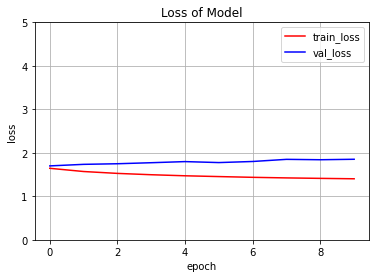

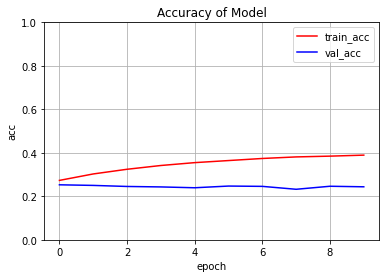

In [17]:
# plot the loss and accuracy of train and val 
loss_type = "epoch"
history.loss_plot_loss(loss_type)
history.loss_plot_acc(loss_type)

In [18]:
# evaluate test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score of test dataset:', score[0])
print('Test accuracy of test dataset:', score[1])

Test score of test dataset: 1.8572584390640259
Test accuracy of test dataset: 0.2369040697813034


In [19]:
# get the data
call_return = history.get_loss_and_acc()
call_return_df = pd.DataFrame(call_return)
call_return_df

,train_loss,train_acc,val_loss,val_acc
0,1.644047,0.273194,1.699276,0.25294
1,1.570164,0.302832,1.735023,0.25016
2,1.526942,0.324369,1.748957,0.24528
3,1.496221,0.341725,1.772540,0.24316
4,1.471947,0.354886,1.798055,0.23932
5,1.453868,0.364432,1.775766,0.24714
6,1.436586,0.374001,1.800832,0.24574
7,1.423212,0.381195,1.849935,0.23234
8,1.412586,0.384748,1.841018,0.24626
9,1.403170,0.389384,1.851921,0.24376


In [20]:
# save the data
! pip install openpyxl
call_return_df.to_excel('lstm_loss_acc.xlsx')

### Load Model And Print the Posibility

In [21]:
load_model = keras.models.load_model('model/lstm_model')

In [22]:
y_pred = load_model.predict(X_test)
y_pred

array([[3.2597780e-04, 3.6897266e-01, 8.3527738e-01, ..., 8.9058805e-01,
        9.0203333e-01, 7.6019132e-01],
       [2.0784995e-10, 3.0900541e-01, 9.9372578e-01, ..., 9.9786520e-01,
        9.9465752e-01, 8.8323396e-01],
       [4.4609308e-03, 4.6355349e-01, 5.9230316e-01, ..., 4.7803706e-01,
        5.5629414e-01, 4.9986187e-01],
       ...,
       [1.0357414e-05, 3.6110333e-01, 9.0660381e-01, ..., 9.1483653e-01,
        8.8176763e-01, 5.5388337e-01],
       [2.6979148e-03, 3.6258185e-01, 5.8529121e-01, ..., 6.5657490e-01,
        7.8674543e-01, 7.5329822e-01],
       [1.1647910e-02, 4.5994356e-01, 6.9631422e-01, ..., 6.1329991e-01,
        5.9897548e-01, 3.3651870e-01]], dtype=float32)

In [23]:
np.save('y_lstm.npy',y_pred)